In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley, MonteCarloShapleyBatch
from shapkit.sgd_shapley import SGDshapley
from shapkit.plots import plot_shapley

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from catboost import CatBoostRegressor, Pool
except:
    ! pip install catboost 

# Load dataset

In [3]:
df = pd.read_csv("../dataset/bike/hour.csv")
df = df.drop(columns=["instant", "dteday", "yr"])
cat_features = ["season", "mnth", "hr", "holiday", "weekday", "workingday", "weathersit"]
df[cat_features] = df[cat_features].astype("str")
df.head(3)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [4]:
target_names = 'cnt'
columns = [col for col in df.columns if col != target_names]
X = df[columns].copy()
y = df[target_names].copy()

In [5]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)


# Train a ML model

In [6]:
cat_features_index = [i for i, col in enumerate(X.columns) if col in cat_features]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.33,
                                                  random_state=42)
test_data = catboost_pool = Pool(X_test, y_test,
                                 cat_features=cat_features_index)
val_data = catboost_pool = Pool(X_val, y_val,
                                cat_features=cat_features_index)
model = CatBoostRegressor(iterations=1000, depth=3,
                           learning_rate=1,
                           loss_function='RMSE',
                           verbose=100)
# train the model
model.fit(X_train, y_train,
          cat_features=cat_features_index,
          eval_set=val_data)

# make the prediction using the resulting model
preds = model.predict(test_data)
rmse = np.sqrt(np.mean((preds - y_test)**2))
print("Test RMSE: {0:.2}".format(rmse))

0:	learn: 72.0079582	test: 68.8890183	best: 68.8890183 (0)	total: 52.9ms	remaining: 52.9s
100:	learn: 3.3868955	test: 4.0279568	best: 3.9496225 (95)	total: 399ms	remaining: 3.55s
200:	learn: 2.2990130	test: 3.3573326	best: 3.3573326 (200)	total: 594ms	remaining: 2.36s
300:	learn: 1.8800424	test: 3.2616370	best: 3.2345658 (291)	total: 857ms	remaining: 1.99s
400:	learn: 1.6002957	test: 3.1736670	best: 3.1580785 (393)	total: 1.17s	remaining: 1.74s
500:	learn: 1.4201456	test: 3.1613384	best: 3.1245929 (474)	total: 1.64s	remaining: 1.63s
600:	learn: 1.2939205	test: 3.1592655	best: 3.1245929 (474)	total: 1.93s	remaining: 1.28s
700:	learn: 1.1926415	test: 3.1446594	best: 3.1245929 (474)	total: 2.4s	remaining: 1.02s
800:	learn: 1.0794685	test: 3.1767016	best: 3.1245929 (474)	total: 2.61s	remaining: 649ms
900:	learn: 1.0107002	test: 3.1520059	best: 3.1245929 (474)	total: 2.88s	remaining: 317ms
999:	learn: 0.9582450	test: 3.1601631	best: 3.1245929 (474)	total: 3.12s	remaining: 0us

bestTest = 3.

# Define the reward function

In [7]:
fc = lambda x: model.predict(x)

# Pick an individual x to explain

In [8]:
x = X_test.iloc[np.random.choice(len(X_test), size=1)[0],:]
print(x)
print()
print("Prediction for x: {0:.0f}".format(model.predict(x.values)))

season             4
mnth              10
hr                 0
holiday            0
weekday            0
workingday         0
weathersit         1
temp            0.44
atemp         0.4394
hum             0.54
windspeed     0.1642
casual            35
registered       119
Name: 15691, dtype: object

Prediction for x: 153


# Single reference

In [9]:
reference = X_train.iloc[np.random.choice(len(X_train), size=1)[0],:]
print(reference)
print()
print("Prediction for this reference: {0:.0f}".format(model.predict(reference.values)))

season             2
mnth               5
hr                 5
holiday            0
weekday            4
workingday         1
weathersit         2
temp             0.6
atemp         0.5455
hum             0.88
windspeed     0.0896
casual             2
registered        25
Name: 3391, dtype: object

Prediction for this reference: 27


# Exact Shapley Values

In [10]:
true_shap = ShapleyValues(x=x, fc=fc, ref=reference)

100%|██████████| 13/13 [01:00<00:00,  4.65s/it]


In [11]:
true_shap

season        -0.005888
mnth           0.147131
hr             0.000000
holiday        0.000000
weekday        0.097870
workingday     0.000000
weathersit     0.119126
temp           0.162239
atemp         -0.024950
hum            0.076893
windspeed     -0.045468
casual        32.400420
registered    93.625255
dtype: float64

# Approximation methods

## Monte Carlo 

In [12]:
mc_shap = MonteCarloShapley(x=x, fc=fc, ref=reference, n_iter=1000)
mc_shap

  0%|          | 4/1000 [00:00<00:25, 39.08it/s]

new dimension 12


100%|██████████| 1000/1000 [00:18<00:00, 55.29it/s]


season        -0.004953
mnth           0.146485
hr             0.000000
holiday        0.000000
weekday        0.099323
workingday     0.000000
weathersit     0.118566
temp           0.162532
atemp         -0.025269
hum            0.075032
windspeed     -0.045468
casual        32.405684
registered    93.620693
dtype: float64

In [13]:
%%time
mc_shap_batch = MonteCarloShapleyBatch(x=x, fc=model.predict, ref=reference, n_iter=1000)
mc_shap_batch

CPU times: user 88 ms, sys: 7.86 ms, total: 95.9 ms
Wall time: 68.2 ms


season        -0.018034
mnth           0.159961
hr             0.000000
holiday        0.000000
weekday        0.095219
workingday     0.000000
weathersit     0.118292
temp           0.162891
atemp         -0.025109
hum            0.081028
windspeed     -0.045468
casual        32.401495
registered    93.622352
dtype: float64

## SGD

In [14]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc, ref=reference, n_iter=5000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 5000/5000 [00:05<00:00, 959.94it/s] 


season         0.202144
mnth           0.513966
hr             0.082878
holiday        0.984934
weekday       -0.176972
workingday     0.470543
weathersit     0.467657
temp           0.100849
atemp         -0.645047
hum           -0.041214
windspeed      0.099726
casual        31.768089
registered    92.725075
dtype: float64

# Plot 

/home/sgrah/Documents/shapkit/tutorials/shapkit/plots.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.get_axes()[0].set_xticklabels(xticks_label)


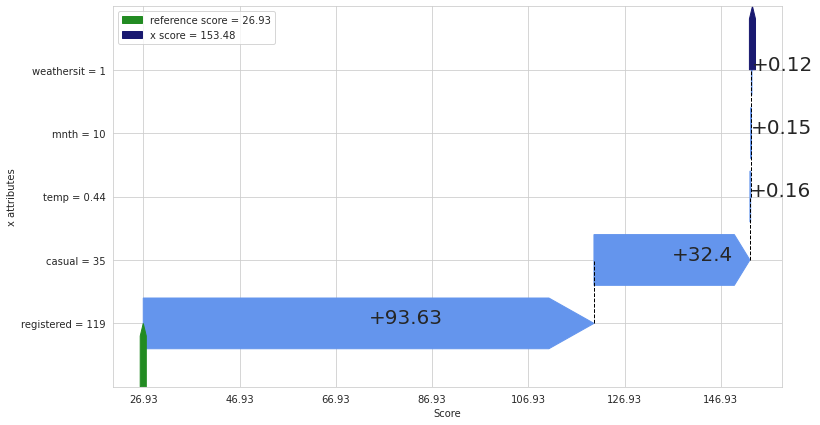

In [15]:
plot_shapley(x=x, fc=fc, ref=reference, shapley_values=true_shap, n_attributes=5)

# Several references 

In [16]:
n_ref = 100
idx_ref = np.random.choice(X_train.shape[0], size=n_ref, replace=False).flatten()
references = X_train.iloc[idx_ref]
references.head(5)

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
2135,2,4,20,0,0,0,3,0.42,0.4242,0.41,0.2239,24,55
5167,3,8,5,0,1,1,1,0.70,0.6667,0.79,0.0896,1,14
11454,2,4,11,0,5,1,1,0.44,0.4394,0.38,0.3284,47,186
13446,3,7,11,0,4,1,1,0.80,0.7576,0.55,0.1045,54,162
8389,1,12,5,0,3,1,2,0.38,0.3939,0.82,0.1045,0,28


# Approximation methods

## Monte Carlo 

In [17]:
mc_shaps = MonteCarloShapley(x=x, fc=fc, ref=references, n_iter=10000)
mc_shaps

100%|██████████| 10000/10000 [02:05<00:00, 79.86it/s]


season         0.000433
mnth           0.036114
hr            -0.202104
holiday        0.000000
weekday        0.042281
workingday     0.000000
weathersit     0.054615
temp           0.282092
atemp          0.140863
hum            0.073168
windspeed      0.017134
casual        -1.869281
registered   -66.599025
dtype: float64

In [22]:
%%time
mc_shaps_batch = MonteCarloShapleyBatch(x=x, fc=model.predict, ref=references, n_iter=10000)
mc_shaps_batch

CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.65 s


season        -0.012637
mnth           0.028360
hr            -0.191162
holiday        0.000000
weekday        0.047520
workingday     0.000000
weathersit     0.052974
temp           0.287205
atemp          0.135246
hum            0.071949
windspeed      0.029875
casual        -2.011853
registered   -70.590805
dtype: float64

# Plots

/home/sgrah/Documents/shapkit/tutorials/shapkit/plots.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.get_axes()[0].set_xticklabels(xticks_label)


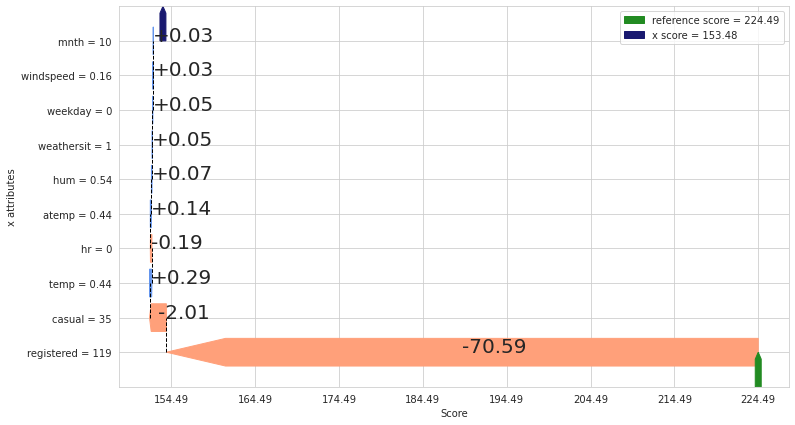

In [23]:
plot_shapley(x=x, fc=fc, ref=references, shapley_values=mc_shaps_batch, n_attributes=10)